# Final Project

*   MIT ADE20K Segmentation Dataset
*   Weights needed to train all by our own (no pretrained weights)




### Colab setting

In [ ]:
!nvidia-smi

Wed Jun  1 02:09:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DV_FinalProject

/content/drive/MyDrive/Colab Notebooks/DV_FinalProject


### Load Data & Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.util.vis_utils import visualizer
from exercise_code.util import save_model
from exercise_code.util.Util import checkSize, checkParams, test, intersectionAndUnion
from exercise_code.networks.segmentation_nn import SegmentationNN, UNet, DummySegmentationModel
from torchvision import transforms
from PIL import Image

#set up default cuda device
print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

cuda:0


In [ ]:
path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(path, 'DV_FinalProject', 'ADE20Kdataset')

train_data = SegmentationData(image_paths_file=f'{data_root}/training.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/validation.txt')

Train size: 20210
Validation size: 2000
Img size:  torch.Size([3, 256, 256])
Segmentation size:  torch.Size([256, 256])


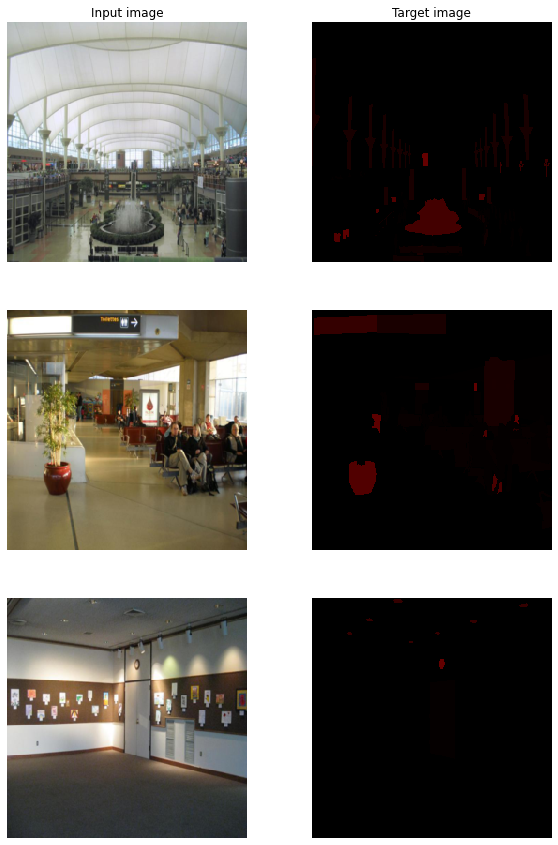

In [ ]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

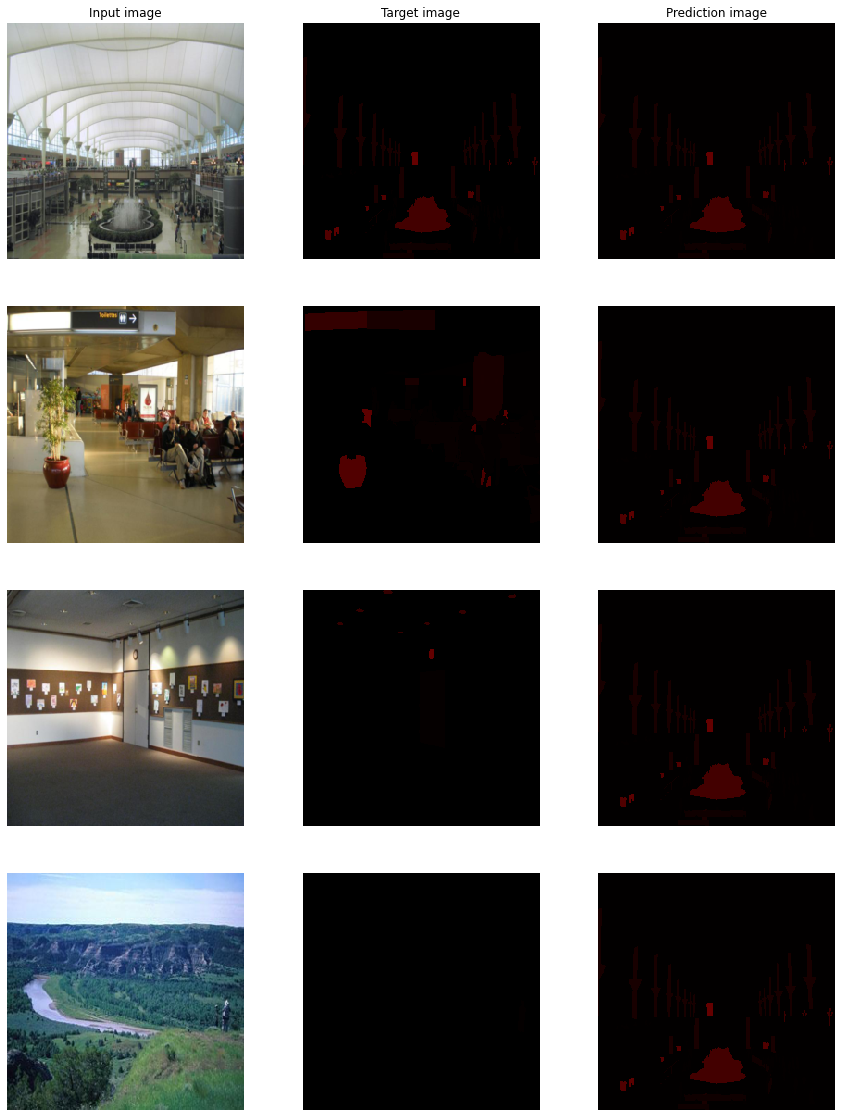

In [ ]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

### Define Model & hyperparameters

In [27]:
hparams = {
    "batch_size": 10,
    "n_epoch": 30
}

In [28]:
model = UNet()

In [29]:
import torch.nn as nn
import torch.optim as optim
import math

train_loss_history = []
train_loss_epoch = []
train_acc_history = []
train_acc_epoch = []
val_loss_history = []
val_loss_epoch = []
val_acc_history = []
val_acc_epoch = []

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=hparams["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=hparams["batch_size"], shuffle=False, num_workers=4, pin_memory=True)

loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.backends.cudnn.benchmark=True
print("current device: ", device)
print()
print(model)

current device:  cuda:0

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

### Load Model from Previous Training Checkpoint

In [23]:
checkpoint = torch.load('./models/unet_dropout_adamW_60epoch_00002_lr.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch_check = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_loss_epoch = checkpoint['train_loss_epoch']
train_acc_epoch = checkpoint['train_acc_epoch']
train_loss_history = checkpoint['train_loss_history']
train_acc_history = checkpoint['train_acc_history']
val_loss_epoch = checkpoint['val_loss_epoch']
val_acc_epoch = checkpoint['val_acc_epoch']
val_loss_history = checkpoint['val_loss_history']
val_acc_history = checkpoint['val_acc_history']

In [30]:
model.load_state_dict(torch.load('./weights/unet_weights.pt'))

<All keys matched successfully>

### Training & Validation

In [ ]:
# train_loss = 0.0
# val_loss = 0.0

# for epoch in range(hparams["n_epoch"]):
for epoch in range(epoch_check, epoch_check+10):
    # Training
    model.train()
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        if math.isnan(loss):
            continue
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loss_history.append(loss.item())
        _, preds = torch.max(y_pred, 1)
        target_mask = y >= 0
        train_acc = np.mean((preds.cpu() == y.cpu())[target_mask].numpy())
        train_acc_history.append(train_acc)

        if i % 100 == 99:
            print("[Epoch %3d, Iteration %4d/%4d] TRAIN loss: %f" % (epoch+1, i+1, len(train_data) / hparams["batch_size"], train_loss / (len(train_dataloader) * epoch + i + 1)))
  

    avg_train_acc, avg_train_loss = np.mean(train_acc_history), np.mean(train_loss_history)
    train_loss_epoch.append(avg_train_loss)
    train_acc_epoch.append(avg_train_acc)
    
    # Validation
    sched_val_loss = 0
    model.eval()
    for i, (x, y) in enumerate(val_dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            if math.isnan(loss):
                continue
            
        val_loss += loss.item()
        sched_val_loss += loss.item()
        
        val_loss_history.append(loss.item())
        _, preds = torch.max(y_pred, 1)
        target_mask = y >= 0
        val_acc_history.append(np.mean((preds.cpu() == y.cpu())[target_mask].detach().cpu().numpy()))
        
        if i % 30 == 29:
            print("[Epoch %3d, Iteration %4d/%4d] VAL   loss: %f" % (epoch+1, i+1, len(val_data) / hparams["batch_size"], val_loss / (len(val_dataloader) * epoch + i + 1)))
    
    scheduler.step(sched_val_loss)
    
    avg_val_acc, avg_val_loss = np.mean(val_acc_history), np.mean(val_loss_history)
    print("avg val acc: %f" % (avg_val_acc))
    val_loss_epoch.append(avg_val_loss)
    val_acc_epoch.append(avg_val_acc)

In [ ]:
plt.title('Loss curves')
plt.plot(train_loss_epoch, '-', label='train')
plt.plot(val_loss_epoch, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.title('Accuracy curves')
plt.plot(train_acc_epoch, '-', label='train')
plt.plot(val_acc_epoch, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.eval()
visualizer(model, val_data)

### Mean IoU Calculation

#### Validation

In [ ]:
inters = 0
unions = 0
model.eval()
for i, (img, target) in enumerate(val_data):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)

    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()

    img, target, pred = img.numpy(), target.numpy(), pred.numpy()

    intersection, union = intersectionAndUnion(pred, target, 100)
    inters += intersection
    unions += union

iou = inters / (unions + 1e-10)
print(iou)
print("Mean IoU: %f" %(iou.mean() * 100))


#### Training

In [ ]:
inters = 0
unions = 0
model.eval()
for i, (img, target) in enumerate(train_data):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)

    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()

    img, target, pred = img.numpy(), target.numpy(), pred.numpy()

    intersection, union = intersectionAndUnion(pred, target, 100)
    inters += intersection
    unions += union

iou = inters / (unions + 1e-10)
# print(iou)
print("Mean IoU: %f" %(iou.mean() * 100))


Mean IoU: 62.867832


### Save Model for resume training

In [ ]:
os.makedirs('models', exist_ok=True)
torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_loss_epoch': train_loss_epoch,
            'train_acc_epoch': train_acc_epoch,
            'train_loss_history': train_loss_history,
            'train_acc_history': train_acc_history,
            'val_loss_epoch': val_loss_epoch,
            'val_acc_epoch': val_acc_epoch,
            'val_loss_history': val_loss_history,
            'val_acc_history': val_acc_history,
            }, "./models/unet_dropout_adamW_60epoch_00002_lr.pt")

### Save weights

In [ ]:
os.makedirs('weights', exist_ok=True)
torch.save(model.state_dict(), "./weights/unet_weights.pt")